In [1]:
import pickle 
import pandas as pd
import xgboost as xgb
import random
import numpy as np
import os, sys

from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from sklearn import metrics

module_path = os.path.abspath(os.path.join('CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as cate_models_masks


def normalize_data(X_train):
    
    X_normalized_train = (X_train - np.min(X_train, axis=0)) / (np.max(X_train, axis=0) - np.min(X_train, axis=0))

    return X_normalized_train

/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Responder cohort analysis

In [32]:
fluid_cohort = pd.read_pickle("data/trauma_responder.pkl")


all_year = pd.read_csv("data/all_year.csv", index_col=0)

fluid_cohort = pd.merge(fluid_cohort,all_year[['registryid','iss']],on='registryid', how='left')
fluid_cohort["iss"] = pd.to_numeric(fluid_cohort["iss"], errors='coerce')

#
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='proc')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='ethnicity')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='residencestate')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='toxicologyresults')))]


x = fluid_cohort.loc[:, ~fluid_cohort.columns.isin(["registryid",
                                                            "COV",
                                                            "TT",
                                                            "scenegcsmotor",
                                                            "scenegcseye",
                                                            "scenegcsverbal",
                                                            "edgcsmotor",
                                                            "edgcseye",
                                                            "edgcsverbal",
                                                            "outcome",
                                                            "sex_F",
                                                            "traumatype_P",
                                                            "traumatype_other"
                                                            ])]

# x = fluid_cohort.loc[:, ~fluid_cohort.columns.isin(["registryid",
#                                                             "COV",
#                                                             "TT", 
#                                                             "scenegcsmotor",
#                                                             "scenegcseye",
#                                                             "scenegcsverbal",
#                                                             "edgcsmotor",
#                                                             "edgcseye",
#                                                             "edgcsverbal",
#                                                             "outcome"])]

### normalize x_train 
#x = x_train.values 

n, feature_size = x.shape
names = x.drop(["treated"], axis=1).columns
treatment_index = x.columns.get_loc("treated")
iss_index = x.columns.get_loc("iss")
sex_index = x.columns.get_loc("sex_M")

var_index = [i for i in range(feature_size) if i != treatment_index and i != iss_index]

x_norm = normalize_data(x)

## impute missing value

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_norm)
x_train_scaled = imp.transform(x_norm)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             fluid_cohort["outcome"], 
                                             test_size=0.2, 
                                             random_state=10,
                                             stratify=fluid_cohort["treated"]
                                    )

w_train = X_train[:, treatment_index]
w_test =  X_test[:, treatment_index]


iss_train = X_train[:, iss_index]
iss_test =  X_test[:, iss_index]

X_train = X_train[:,var_index]
X_test = X_test[:, var_index]

/tmp/ipykernel_31804/4139024282.py:4: DtypeWarning: Columns (9,16,45,57,58,59,60,61,62,63,64,71,84) have mixed types. Specify dtype option on import or set low_memory=False.
  all_year = pd.read_csv("data/all_year.csv", index_col=0)


In [34]:
results_train = pickle.load(open("results/responder/result_train_responder_xlearner.pkl", "rb"))
results_test = pickle.load(open("results/responder/result_test_responder_xlearner.pkl", "rb"))

results_train = results_train.reshape(5, -1)
results_test = results_test.reshape(5, -1)

print(np.mean(results_train), np.std(results_train)/np.sqrt(results_train.shape[1]))
print(np.mean(results_test), np.std(results_test)/np.sqrt(results_test.shape[1]))

estimated_ate_train = np.mean(results_train, axis=0)
estimated_ate_test = np.mean(results_test, axis=0)

threshold = np.mean(estimated_ate_train)

gender = x.columns.get_loc("sex_M")
cause_MV = x.columns.get_loc("causecode_MV")
cause_GUN = x.columns.get_loc("causecode_GUN")
scenegcs = x.columns.get_loc("scenegcs")
trauma = x.columns.get_loc("traumatype_B")
scenefirstbloodpressure = x.columns.get_loc("scenefirstbloodpressure")


lac  = x.columns.get_loc("LAC")
inr  = x.columns.get_loc("INR")
hgb  = x.columns.get_loc("HGB")
ph = x.columns.get_loc("PH")
fio2 = x.columns.get_loc("FIO2")
na = x.columns.get_loc("NA")
temp = x.columns.get_loc("temps2")
bd = x.columns.get_loc("BD")
pulse = x.columns.get_loc("edfirstpulse")



y_true_train = (estimated_ate_train > threshold)
y_true_test = (estimated_ate_test > threshold)

top_2_train = X_train[:, [trauma ,cause_MV, scenegcs, cause_GUN ]]
top_2_test = X_test[:, [trauma ,cause_MV, scenegcs, cause_GUN]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)

ate = np.sum(estimated_ate_test[y_pred == 1])/n

auroc = metrics.roc_auc_score(y_true_test, y_pred)

print("original", np.sum(estimated_ate_test[w_test==1])/n)

print("shap",auroc)
print("shap - ate:", ate)
print("shap - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


top_2_train = X_train[:, [temp, ph, bd, hgb, pulse ]]
top_2_test = X_test[:, [temp, ph, bd, hgb, pulse ]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)

ate = np.sum(estimated_ate_test[y_pred == 1])/n

auroc = metrics.roc_auc_score(y_true_test, y_pred)

print("shap- 0",auroc)
print("shap-0 - ate", ate)
print("shap-0 - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


top_2_train = X_train[:, [ph, na, temp, gender, fio2 ]]
top_2_test = X_test[:, [ph, na, temp, gender, fio2 ]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)

auroc = metrics.roc_auc_score(y_true_test, y_pred)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

print("ig",auroc)
print("ig - ate", ate)
print("ig - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


top_2_train = X_train[:, [lac, inr, hgb,scenefirstbloodpressure ]]
top_2_test = X_test[:, [lac, inr,hgb, scenefirstbloodpressure ]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)

auroc = metrics.roc_auc_score(y_true_test, y_pred)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

print("clnical", auroc)
print("clinical - ate", ate)
print("clinical - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(X_train, y_true_train)

y_pred = xgb_model.predict(X_test)

ate = np.sum(estimated_ate_test[y_pred == 1])/n
auroc = metrics.roc_auc_score(y_true_test, y_pred)

print("full feature", auroc)
print("full feature - ate", ate)
print("full - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


random_feature = np.random.randint(X_train.shape[1], size=(4))

top_2_train = X_train[:, random_feature]
top_2_test = X_test[:, random_feature]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)

ate = np.sum(estimated_ate_test[y_pred == 1])/n

auroc = metrics.roc_auc_score(y_true_test, y_pred)

print("random feature", auroc)
print("random feature - ate", ate)
print("random - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


0.014403417111102866 0.01822509105776346
0.019069704216733378 0.03517305039331138
original 0.003058094507370424
shap 0.7145713788906277
shap - ate: 0.012433164428836112
shap - iss  29.845238095238095 29.529411764705884
shap- 0 0.547209181011998
shap-0 - ate 0.0025370662854015042
shap-0 - iss  30.134831460674157 29.0952380952381
ig 0.5304294905233872
ig - ate 0.0045667647204959425
ig - iss  29.073170731707318 30.442857142857147
clnical 0.5532950791166754
clinical - ate 0.0027846100569576303
clinical - iss  30.346666666666668 29.07792207792208
full feature 0.6969222743870631
full feature - ate 0.011469007882735005
full - iss  28.721518987341774 30.76712328767123
random feature 0.5772909059294036
random feature - ate 0.00511608553782832
random - iss  30.576576576576578 27.341463414634145


## Transfusion 

In [19]:



fluid_cohort = pd.read_pickle("data/low_bp_survival.pkl")

all_year = pd.read_csv("data/all_year.csv", index_col=0)

fluid_cohort = pd.merge(fluid_cohort,all_year[['registryid','iss']],on='registryid', how='left')
fluid_cohort["iss"] = pd.to_numeric(fluid_cohort["iss"], errors='coerce')

print(np.min(fluid_cohort["iss"]), np.max(fluid_cohort["iss"]))
#
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='proc')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='ethnicity')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='residencestate')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='toxicologyresults')))]


x = fluid_cohort.loc[:, ~fluid_cohort.columns.isin(["registryid",
                                                    "COV",
                                                    "TT",
                                                    "scenegcsmotor",
                                                    "scenegcseye",
                                                    "scenegcsverbal",
                                                    "edgcsmotor",
                                                    "edgcseye",
                                                    "edgcsverbal",
                                                    "outcome",
                                                    "sex_F",
                                                    "traumatype_P",
                                                    "traumatype_other",
                                                ])
                    ]

n, feature_size = x.shape
names = x.drop(["treated"], axis=1).columns
treatment_index = x.columns.get_loc("treated")
iss_index = x.columns.get_loc("iss")
sex_index = x.columns.get_loc("sex_M")

var_index = [i for i in range(feature_size) if i != treatment_index and i != iss_index]

x_norm = normalize_data(x)

## impute missing value

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_norm)
x_train_scaled = imp.transform(x_norm)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             fluid_cohort["outcome"], 
                                             test_size=0.2, 
                                             random_state=10,
                                             stratify=fluid_cohort["treated"]
                                    )

w_train = X_train[:, treatment_index]
w_test =  X_test[:, treatment_index]

iss_train = X_train[:, iss_index]
iss_test =  X_test[:, iss_index]

X_train = X_train[:,var_index]
X_test = X_test[:, var_index]

/tmp/ipykernel_31804/2458007031.py:12: DtypeWarning: Columns (9,16,45,57,58,59,60,61,62,63,64,71,84) have mixed types. Specify dtype option on import or set low_memory=False.
  all_year = pd.read_csv("data/all_year.csv", index_col=0)


1.0 75.0


In [21]:
import pickle 
import xgboost as xgb
import random
from sklearn import metrics


results_train = pickle.load(open("results/massive_trans/result_train_xlearner.pkl", "rb"))
results_test = pickle.load(open("results/massive_trans/result_test_xlearner.pkl", "rb"))

print(results_test.shape)
results_train = results_train.reshape(5, -1)
results_test = results_test.reshape(5, -1)

print(np.mean(results_train), np.std(results_train)/np.sqrt(results_train.shape[1]))
print(np.mean(results_test), np.std(results_test)/np.sqrt(results_test.shape[1]))

estimated_ate_train = np.mean(results_train, axis=0)
estimated_ate_test = np.mean(results_test, axis=0)

print(estimated_ate_test.shape)
threshold = np.mean(estimated_ate_train)

trauma = x.columns.get_loc("traumatype_B")
gender = x.columns.get_loc("sex_M")
temp = x.columns.get_loc("temps2")
fio2 = x.columns.get_loc("FIO2")
ph = x.columns.get_loc("PH")

cause_cut = x.columns.get_loc("causecode_CUT")
cause_mv = x.columns.get_loc("causecode_MV")
edgcs = x.columns.get_loc("edgcs")
hgb  = x.columns.get_loc("HGB")
na = x.columns.get_loc("NA")

scenefirstbloodpressure = x.columns.get_loc("scenefirstbloodpressure")


lac  = x.columns.get_loc("LAC")
inr  = x.columns.get_loc("INR")

bd = x.columns.get_loc("BD")
pulse = x.columns.get_loc("edfirstpulse")


y_true_train = (estimated_ate_train > threshold)
y_true_test = (estimated_ate_test > threshold)

top_5_train = X_train[:, [gender,trauma ,cause_cut, edgcs, cause_mv ]]
top_5_test = X_test[:, [gender, trauma ,cause_cut, edgcs, cause_mv]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_5_train, y_true_train)

y_pred = xgb_model.predict(top_5_test)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

auroc = metrics.roc_auc_score(y_true_test, y_pred)

print("original", np.sum(estimated_ate_test[w_test==1])/n)

print("shap",auroc)
print("shap - ate", ate)
print("shap - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


top_2_train = X_train[:, [temp, ph, bd, hgb, trauma ]]
top_2_test = X_test[:, [temp, ph, bd, hgb, trauma ]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)
auroc = metrics.roc_auc_score(y_true_test, y_pred)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

print("shap- 0",auroc)
print("shap-0 - ate", ate)
print("shap - 0 iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


top_2_train = X_train[:, [ph, na, temp, gender, trauma ]]
top_2_test = X_test[:, [ph, na, temp, gender, trauma ]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)
auroc = metrics.roc_auc_score(y_true_test, y_pred)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

print("ig",auroc)
print("ig - ate", ate)
print("ig - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


top_2_train = X_train[:, [lac, inr, hgb, trauma,scenefirstbloodpressure ]]
top_2_test = X_test[:, [lac, inr,hgb,trauma, scenefirstbloodpressure ]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)
auroc = metrics.roc_auc_score(y_true_test, y_pred)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

print("clnical", auroc)
print("clinical - ate", ate)
print("clinical - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(X_train, y_true_train)

y_pred = xgb_model.predict(X_test)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

auroc = metrics.roc_auc_score(y_true_test, y_pred)

print("full feature", auroc)
print("full feature - ate", ate)

random_feature = np.random.randint(X_train.shape[1], size=(4))

top_2_train = X_train[:, random_feature]
top_2_test = X_test[:, random_feature]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

auroc = metrics.roc_auc_score(y_true_test, y_pred)

print("random feature", auroc)
print("random feature - ate", ate)
print("random - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


(5, 201)
-0.023062477658597282 0.00899912391591147
-0.022944787911959547 0.017713969099360866
(201,)
original -0.00023330417962603807
shap 0.6174985145573382
shap - ate 0.001437606120786344
shap - iss  25.78494623655914 32.96296296296296
shap- 0 0.5372846108140226
shap-0 - ate -0.0007112733564298764
shap - 0 iss  27.15841584158416 32.150000000000006
ig 0.5671420083184788
ig - ate -0.0009134202669615827
ig - iss  26.287128712871283 33.03000000000001
clnical 0.5775401069518717
clinical - ate 0.0008943701730632923
clinical - iss  27.126315789473683 31.896226415094343
full feature 0.6959298871063577
full feature - ate 0.004188320494861717
random feature 0.5111408199643493
random feature - ate -0.002900782363318589
random - iss  30.203389830508474 28.843373493975907


(array([ 2., 18.,  8.,  6.,  0.,  2.,  3.,  0.,  0.,  2.]),
 array([ 9. , 15.6, 22.2, 28.8, 35.4, 42. , 48.6, 55.2, 61.8, 68.4, 75. ]),
 <BarContainer object of 10 artists>)

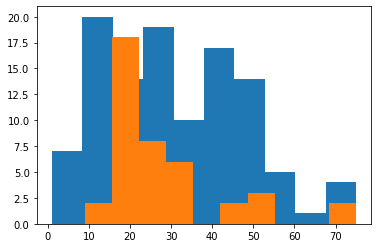

In [39]:
import matplotlib.pyplot as plt 

plt.hist(iss_test[y_pred==1]*74+1)
plt.hist(iss_test[y_pred==0]*74+1)